In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import sys, os
import pandas as pd

sys.path.append('../ConformalizedES')
sys.path.append('../third_party')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()
    

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

def plot_pvals(pvals, labels):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]

    pvals_in = np.array(pvals)[idx_in]
    pvals_out = np.array(pvals)[idx_out]

    plt.figure(figsize=(8,6))
    plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
    plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
    plt.legend()
    plt.show

    print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
          .format(np.mean(pvals_in), np.mean(pvals_out)))

In [3]:
from torch.utils.data import Dataset
from sklearn.datasets import make_blobs

class Blob_dataset(Dataset):
    def __init__(self,n_samples, centers, n_features, std):
        self.X, self.y = make_blobs(n_samples=n_samples, centers=centers, 
                          n_features=n_features, cluster_std=std)
        self.X = self.X.astype('float32')
        self.y = self.y.astype('int64')
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [4]:
def split_data(seed, train_set, n_train_bm, n_val_bm, n_cal_bm, batch_size=10, num_workers=0):
    np.random.seed(seed)
    th.manual_seed(seed)

    # MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
    # Benchmark data splitting: equally split the data into 3 sets
    n_full = len(train_set)
    n_data = n_train_bm + n_val_bm + n_cal_bm

    train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                     [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

    # CES data splitting: calibration set is not needed, merge back to the training set
    n_train_ces = n_train_bm + n_val_bm
    n_val_ces = n_cal_bm

    train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                     [n_train_ces, n_val_ces, n_full-n_data])
    
    train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

    val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=n_val_bm,
                                              num_workers=num_workers)

    cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=n_cal_bm,
                                              num_workers=num_workers)

    # For CES
    train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                              num_workers=num_workers)

    val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=n_val_ces,
                                              num_workers=num_workers)
    return train_loader_bm, val_loader_bm, cal_loader_bm, train_loader_ces, val_loader_ces


# def split_data(seed, train_set, n_train_bm, n_val_bm, batch_size=10, num_workers=0):
#     np.random.seed(seed)
#     th.manual_seed(seed)

#     # MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
#     # Benchmark data splitting: equally split the data into 3 sets
#     n_full = len(train_set)
#     n_data = n_train_bm + n_val_bm

#     train_set_bm, val_set_bm, _ = th.utils.data.random_split(train_set,\
#                                      [n_train_bm, n_val_bm, n_full-n_data])

#     # CES data splitting: calibration set is not needed, merge back to the training set
#     n_train_ces = n_train_bm + n_val_bm

#     train_set_ces, _ = th.utils.data.random_split(train_set,\
#                                      [n_train_ces, n_full-n_data])
    
#     train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
#                                           num_workers=num_workers)

#     val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=n_val_bm,
#                                               num_workers=num_workers)

#     # For CES
#     train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
#                                               num_workers=num_workers)

#     return train_loader_bm, val_loader_bm, train_loader_ces

def load_test(seed, test_set, n_test, num_workers=0):
    np.random.seed(seed)
    th.manual_seed(seed)

    test_sampler = SubsetRandomSampler(np.arange(n_test, dtype=np.int64))
    test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test, sampler=test_sampler,
                                             num_workers=num_workers)

    # get all test images
    dataiter = iter(test_loader)
    inputs, labels = dataiter.next()
    return inputs, labels

# def load_cal(seed, cal_set, n_cal, num_workers=0):
#     np.random.seed(seed)
#     th.manual_seed(seed)

#     cal_sampler = SubsetRandomSampler(np.arange(n_cal, dtype=np.int64))
#     cal_loader = th.utils.data.DataLoader(cal_set, batch_size=n_test, sampler=cal_sampler,
#                                              num_workers=num_workers)

#     return cal_loader

In [5]:
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import pdb

class SimpleNN(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_size=32):
        super(SimpleNN, self).__init__()
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.hidden_size = hidden_size
    
        self.build_model()
        self.init_weights()
        
    def init_weights(self):
        for m in self.base_model:
            if isinstance(m, nn.Linear):
                th.nn.init.xavier_uniform(m.weight)
                m.bias.data.fill_(0.01)
    
    def build_model(self):
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.out_shape),
        )
        
    def forward(self, x):
        """
        Forward pass
        """
        return self.base_model(x)
    
    def predict_prob(self, inputs):
        """
        Predict probabilities given any input data
        """
        self.eval()
       
        get_prob = nn.Softmax(dim = 1)
        with th.no_grad():
            logits = self(inputs)    # Assume inputs are already on the correct device
            prob = get_prob(logits).cpu().numpy()
        return prob
    
    def get_anomaly_scores(self,inputs):
#         pdb.set_trace()
        if len(inputs.shape) == 1:
            inputs = inputs[None,]
        full_prob = self.predict_prob(inputs)
        return list(full_prob[:,1])
    

class SimpleAE(nn.Module):
    def __init__(self, in_shape, hidden_size1 = 32, hidden_size2 = 10):
        super(SimpleAE, self).__init__()
        
        self.in_shape = in_shape
        self.hidden_size1= hidden_size1
        self.hidden_size2= hidden_size2
    
        self.build_model()
        self.init_weights()
        
    def init_weights(self):
        for m in self.base_model:
            if isinstance(m, nn.Linear):
                th.nn.init.xavier_uniform(m.weight)
                m.bias.data.fill_(0.01)
    
    def build_model(self):
        self.base_model = nn.Sequential(
            # Encoder part
            nn.Linear(self.in_shape, self.hidden_size1),
            nn.ReLU(),
            nn.Linear(self.hidden_size1, self.hidden_size2),
            nn.ReLU(),
            
            # Decoder part
            nn.Linear(self.hidden_size2, self.hidden_size1),
            nn.ReLU(),
            nn.Linear(self.hidden_size1, self.in_shape),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        """
        Forward pass
        """
        return self.base_model(x)
    
    def get_anomaly_scores(self,inputs):
        self.eval()
        with th.no_grad():
            outputs = self(inputs)
            Loss = th.nn.MSELoss(reduction='none')
            scores = Loss(outputs.reshape(-1, self.in_shape), inputs.reshape(-1, self.in_shape))
        
        scores = np.mean(scores.numpy(), axis = 1)
        return list(scores)
    

In [6]:
from method import CES_oneClass
from utils import eval_pvalues
import torch.optim as optim
from inference import Conformal_PVals
import pdb

def run_experiment(seed, train_set, n_train_bm, n_val_bm, n_cal_bm, test_set, n_test,
                   lr, n_epoch, alpha_list, batch_size=10, num_worker=0, visualize=True):
    # Initialize result data frame
    results = pd.DataFrame({})
    
    # Get the dataloaders and test points
    train_loader_bm, val_loader_bm, cal_loader_bm, train_loader_ces, val_loader_ces =\
    split_data(seed, train_set, n_train_bm, n_val_bm, n_cal_bm, batch_size, num_worker)
    inputs, labels = load_test(seed, test_set, n_test)
    
    
    # Define default device, we should use the GPU (cuda) if available
    device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)
    if th.cuda.is_available():
        # Make CuDNN Determinist
        th.backends.cudnn.deterministic = True
        th.cuda.manual_seed(seed)
    # Set the NN parameters 
#     net_bm = SimpleNN(in_shape=inputs.shape[1], out_shape=2)
#     Loss = th.nn.CrossEntropyLoss()
#     def criterion(outputs, inputs, targets):
#         return Loss(outputs, targets)
# #     optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)
#     optimizer_bm = optim.SGD(net_bm.parameters(), lr=lr)
    
    net_bm = SimpleAE(in_shape=inputs.shape[1])
    Loss = th.nn.MSELoss()
    def criterion(outputs, inputs, targets):
        return Loss(outputs, inputs)
    optimizer_bm = optim.SGD(net_bm.parameters(), lr=lr)
    
    np.random.seed(seed)
    th.manual_seed(seed)
    
    # Train with benchmark data splitting
    print("Training with standard data splitting...")
    sys.stdout.flush()
    
    CES_oc_bm = CES_oneClass(net_bm, device, train_loader_bm, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)
    CES_oc_bm.full_train(save_dir = './models/oneClass/exp'+str(seed)+'/benchmarks/', save_every = 1)
    
    if visualize:
        print('The loss history is:', CES_oc_bm.val_loss_history[:10])
        plot_loss_acc(CES_oc_bm.train_loss_history, CES_oc_bm.val_loss_history, 
                      CES_oc_bm.train_acc_history, CES_oc_bm.val_acc_history)
    
    # Compute the benchmark p-values
    print('Computing standard benchmark p-values for {:d} test points...'.format(n_test))
    sys.stdout.flush()
    
    best_loss_bm, best_model_bm, val_loss_history_bm = CES_oc_bm.select_model()
#     pdb.set_trace()
    model_list_bm = CES_oc_bm.model_list
    C_PVals_bm = Conformal_PVals(net_bm, device, cal_loader_bm, model_list_bm, random_state = seed)
    pvals_bm = C_PVals_bm.compute_pvals(inputs, [best_model_bm]*len(inputs))
    results_bm = eval_pvalues(pvals_bm, labels, alpha_list)
    results_bm["Method"] = "Standard benchmark"
    results = pd.concat([results, results_bm])
    
    
    np.random.seed(seed)
    th.manual_seed(seed)

#     net_ces = SimpleNN(in_shape=inputs.shape[1], out_shape=2)
# #     optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)
#     optimizer_ces = optim.SGD(net_ces.parameters(), lr=lr)
    
    net_ces = SimpleAE(in_shape=inputs.shape[1])
    Loss = th.nn.MSELoss()
    def criterion(outputs, inputs, targets):
        return Loss(outputs, inputs)
    optimizer_ces = optim.SGD(net_ces.parameters(), lr=lr)
    
    
    # Initialize the CES class with model parameters
    print("Training with CES data splitting...")
    sys.stdout.flush()
    
    CES_oc_ces = CES_oneClass(net_ces, device, train_loader_ces, batch_size=batch_size, max_epoch=n_epoch, 
                            learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)
    CES_oc_ces.full_train(save_dir = './models/oneClass/exp'+str(seed)+'/ces/', save_every = 1)
    
    if visualize:
        plot_loss_acc(CES_oc_ces.train_loss_history, CES_oc_ces.val_loss_history, 
                      CES_oc_ces.train_acc_history, CES_oc_ces.val_acc_history)
    
    model_list_ces = CES_oc_ces.model_list
    C_PVals_ces = Conformal_PVals(net_ces, device, val_loader_ces, model_list_ces, random_state = seed)
    
    # Compute the benchmark p-values
    print('Computing naive benchmark p-values for {:d} test points...'.format(n_test))
    best_loss_naive, best_model_naive, val_loss_history_naive = CES_oc_ces.select_model()
    pvals_naive = C_PVals_ces.compute_pvals(inputs, [best_model_naive]*len(inputs))
    results_naive = eval_pvalues(pvals_naive, labels, alpha_list)
    results_naive["Method"] = "Naive benchmark"
    results = pd.concat([results, results_naive])
    
    return results


In [7]:
# Define the model parameters
n_train_bm = 100
n_val_bm = 100
n_cal_bm = 10
n_test = 500
lr = 1
alpha_list = [0.1]
n_epoch = 30
n_classes = 2
num_repetitions = 2

# center and standard deviation of the blobs
centers = np.array([[0,0],[3,3]])
null_center =  np.array([[0,0]])
std = 2
n_features = 2
train_set = Blob_dataset(5000, null_center, n_features, std)
test_set = Blob_dataset(5000, centers, n_features, std)

<function matplotlib.pyplot.show(close=None, block=None)>

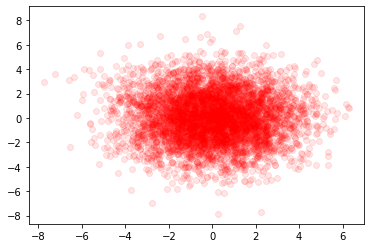

In [8]:
# def plot_blobs(n_classes)
plt.scatter(train_set.X[train_set.y==0][:,0], train_set.X[train_set.y==0][:,1], c='r', alpha=0.1)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

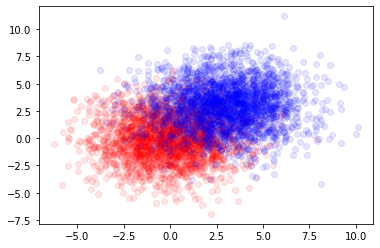

In [9]:
# def plot_blobs(n_classes)
plt.scatter(test_set.X[test_set.y==0][:,0], test_set.X[test_set.y==0][:,1], c='r', alpha=0.1)
plt.scatter(test_set.X[test_set.y==1][:,0], test_set.X[test_set.y==1][:,1], c='b', alpha=0.1)
plt.show


Starting repetition 1 of 2:

Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 30
learning_rate= 1
Epoch 1 of 30, 10% 	 train_loss: 4.49 train_acc: 90.00% took: 0.00s
Epoch 1 of 30, 20% 	 train_loss: 2.33 train_acc: 50.00% took: 0.00s
Epoch 1 of 30, 30% 	 train_loss: 5.78 train_acc: 80.00% took: 0.00s
Epoch 1 of 30, 40% 	 train_loss: 1.96 train_acc: 60.00% took: 0.00s
Epoch 1 of 30, 50% 	 train_loss: 2.19 train_acc: 70.00% took: 0.00s
Epoch 1 of 30, 60% 	 train_loss: 2.97 train_acc: 70.00% took: 0.00s
Epoch 1 of 30, 70% 	 train_loss: 1.96 train_acc: 10.00% took: 0.00s
Epoch 1 of 30, 80% 	 train_loss: 3.80 train_acc: 10.00% took: 0.00s
Epoch 1 of 30, 90% 	 train_loss: 3.89 train_acc: 20.00% took: 0.00s
Epoch 1 of 30, 100% 	 train_loss: 3.20 train_acc: 40.00% took: 0.00s
val_loss = 3.01 val_acc = 28.00%
Snapshot saved at epoch 1.
Epoch 2 of 30, 10% 	 train_loss: 3.68 train_acc: 50.00% took: 0.00s
Epoch 2 of 30, 20% 	 train_loss: 1.67 train_acc

C:\Users\16266\AppData\Local\Temp\ipykernel_17296\2573961132.py:70: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  th.nn.init.xavier_uniform(m.weight)



Epoch 6 of 30, 40% 	 train_loss: 1.51 train_acc: 30.00% took: 0.00s
Epoch 6 of 30, 50% 	 train_loss: 1.98 train_acc: 40.00% took: 0.00s
Epoch 6 of 30, 60% 	 train_loss: 2.53 train_acc: 20.00% took: 0.00s
Epoch 6 of 30, 70% 	 train_loss: 1.59 train_acc: 20.00% took: 0.00s
Epoch 6 of 30, 80% 	 train_loss: 3.12 train_acc: 10.00% took: 0.00s
Epoch 6 of 30, 90% 	 train_loss: 2.22 train_acc: 30.00% took: 0.00s
Epoch 6 of 30, 100% 	 train_loss: 2.38 train_acc: 30.00% took: 0.00s
val_loss = 2.27 val_acc = 15.00%
Snapshot saved at epoch 6.
Epoch 7 of 30, 10% 	 train_loss: 3.12 train_acc: 30.00% took: 0.00s
Epoch 7 of 30, 20% 	 train_loss: 1.52 train_acc: 30.00% took: 0.00s
Epoch 7 of 30, 30% 	 train_loss: 5.18 train_acc: 50.00% took: 0.00s
Epoch 7 of 30, 40% 	 train_loss: 1.51 train_acc: 30.00% took: 0.00s
Epoch 7 of 30, 50% 	 train_loss: 1.98 train_acc: 40.00% took: 0.00s
Epoch 7 of 30, 60% 	 train_loss: 2.53 train_acc: 20.00% took: 0.00s
Epoch 7 of 30, 70% 	 train_loss: 1.60 train_acc: 20.00

Epoch 22 of 30, 40% 	 train_loss: 1.51 train_acc: 30.00% took: 0.00s
Epoch 22 of 30, 50% 	 train_loss: 1.96 train_acc: 40.00% took: 0.00s
Epoch 22 of 30, 60% 	 train_loss: 2.53 train_acc: 20.00% took: 0.00s
Epoch 22 of 30, 70% 	 train_loss: 1.59 train_acc: 30.00% took: 0.00s
Epoch 22 of 30, 80% 	 train_loss: 3.10 train_acc: 10.00% took: 0.00s
Epoch 22 of 30, 90% 	 train_loss: 2.21 train_acc: 30.00% took: 0.00s
Epoch 22 of 30, 100% 	 train_loss: 2.38 train_acc: 30.00% took: 0.00s
val_loss = 2.27 val_acc = 20.00%
Snapshot saved at epoch 22.
Epoch 23 of 30, 10% 	 train_loss: 3.13 train_acc: 50.00% took: 0.00s
Epoch 23 of 30, 20% 	 train_loss: 1.55 train_acc: 30.00% took: 0.00s
Epoch 23 of 30, 30% 	 train_loss: 5.17 train_acc: 60.00% took: 0.00s
Epoch 23 of 30, 40% 	 train_loss: 1.51 train_acc: 30.00% took: 0.01s
Epoch 23 of 30, 50% 	 train_loss: 1.96 train_acc: 40.00% took: 0.00s
Epoch 23 of 30, 60% 	 train_loss: 2.54 train_acc: 20.00% took: 0.00s
Epoch 23 of 30, 70% 	 train_loss: 1.59 tr

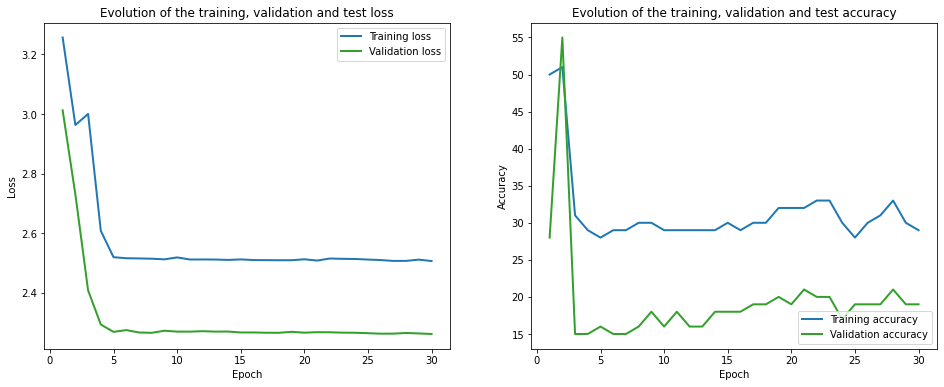

Computing standard benchmark p-values for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.60it/s]


Initialization done!


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 408.79it/s]


Finished computing p-values for 500 test points.
Training with CES data splitting...


C:\Users\16266\AppData\Local\Temp\ipykernel_17296\2573961132.py:70: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  th.nn.init.xavier_uniform(m.weight)


===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 30
learning_rate= 1
Epoch 1 of 30, 10% 	 train_loss: 5.66 train_acc: 5.00% took: 0.01s
Epoch 1 of 30, 20% 	 train_loss: 2.43 train_acc: 60.00% took: 0.01s
Epoch 1 of 30, 30% 	 train_loss: 2.58 train_acc: 50.00% took: 0.01s
Epoch 1 of 30, 40% 	 train_loss: 2.84 train_acc: 45.00% took: 0.01s
Epoch 1 of 30, 50% 	 train_loss: 2.96 train_acc: 50.00% took: 0.01s
Epoch 1 of 30, 60% 	 train_loss: 2.27 train_acc: 50.00% took: 0.01s
Epoch 1 of 30, 70% 	 train_loss: 2.62 train_acc: 65.00% took: 0.01s
Epoch 1 of 30, 80% 	 train_loss: 3.14 train_acc: 65.00% took: 0.01s
Epoch 1 of 30, 90% 	 train_loss: 1.95 train_acc: 80.00% took: 0.01s
Epoch 1 of 30, 100% 	 train_loss: 2.14 train_acc: 55.00% took: 0.01s
val_loss = 2.08 val_acc = 100.00%
Snapshot saved at epoch 1.
Epoch 2 of 30, 10% 	 train_loss: 4.36 train_acc: 70.00% took: 0.01s
Epoch 2 of 30, 20% 	 train_loss: 1.93 train_acc: 70.00% took: 0.01s
Epoch 2 of 30, 30% 	 train_loss: 2.35 train_acc: 6

Epoch 12 of 30, 70% 	 train_loss: 2.56 train_acc: 65.00% took: 0.01s
Epoch 12 of 30, 80% 	 train_loss: 3.07 train_acc: 50.00% took: 0.01s
Epoch 12 of 30, 90% 	 train_loss: 1.91 train_acc: 60.00% took: 0.01s
Epoch 12 of 30, 100% 	 train_loss: 2.09 train_acc: 60.00% took: 0.01s
val_loss = 1.99 val_acc = 60.00%
Snapshot saved at epoch 12.
Epoch 13 of 30, 10% 	 train_loss: 4.03 train_acc: 55.00% took: 0.01s
Epoch 13 of 30, 20% 	 train_loss: 1.90 train_acc: 60.00% took: 0.01s
Epoch 13 of 30, 30% 	 train_loss: 2.21 train_acc: 60.00% took: 0.01s
Epoch 13 of 30, 40% 	 train_loss: 2.51 train_acc: 50.00% took: 0.01s
Epoch 13 of 30, 50% 	 train_loss: 2.68 train_acc: 50.00% took: 0.01s
Epoch 13 of 30, 60% 	 train_loss: 2.17 train_acc: 55.00% took: 0.01s
Epoch 13 of 30, 70% 	 train_loss: 2.56 train_acc: 65.00% took: 0.01s
Epoch 13 of 30, 80% 	 train_loss: 3.07 train_acc: 50.00% took: 0.01s
Epoch 13 of 30, 90% 	 train_loss: 1.91 train_acc: 60.00% took: 0.01s
Epoch 13 of 30, 100% 	 train_loss: 2.10 t

Epoch 25 of 30, 30% 	 train_loss: 2.21 train_acc: 50.00% took: 0.01s
Epoch 25 of 30, 40% 	 train_loss: 2.51 train_acc: 50.00% took: 0.01s
Epoch 25 of 30, 50% 	 train_loss: 2.68 train_acc: 45.00% took: 0.01s
Epoch 25 of 30, 60% 	 train_loss: 2.16 train_acc: 60.00% took: 0.01s
Epoch 25 of 30, 70% 	 train_loss: 2.56 train_acc: 65.00% took: 0.00s
Epoch 25 of 30, 80% 	 train_loss: 3.07 train_acc: 50.00% took: 0.00s
Epoch 25 of 30, 90% 	 train_loss: 1.91 train_acc: 60.00% took: 0.01s
Epoch 25 of 30, 100% 	 train_loss: 2.09 train_acc: 60.00% took: 0.01s
val_loss = 1.99 val_acc = 60.00%
Snapshot saved at epoch 25.
Epoch 26 of 30, 10% 	 train_loss: 4.03 train_acc: 55.00% took: 0.00s
Epoch 26 of 30, 20% 	 train_loss: 1.90 train_acc: 55.00% took: 0.01s
Epoch 26 of 30, 30% 	 train_loss: 2.21 train_acc: 50.00% took: 0.01s
Epoch 26 of 30, 40% 	 train_loss: 2.51 train_acc: 50.00% took: 0.01s
Epoch 26 of 30, 50% 	 train_loss: 2.68 train_acc: 45.00% took: 0.01s
Epoch 26 of 30, 60% 	 train_loss: 2.17 tr

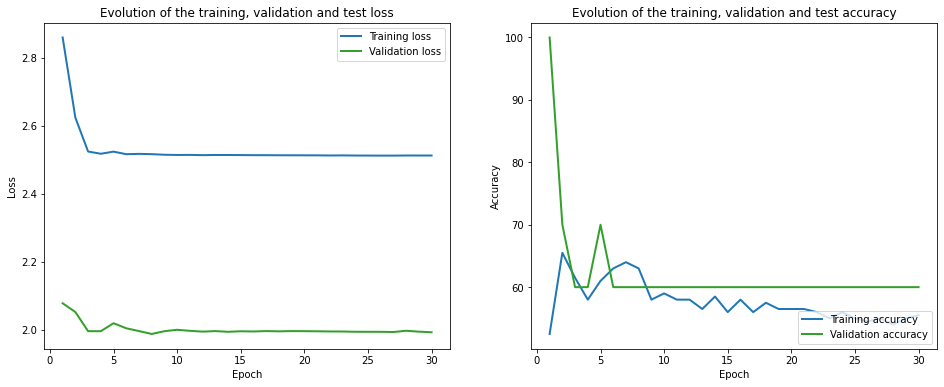

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.25it/s]


Initialization done!
Computing naive benchmark p-values for 500 test points...


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 428.47it/s]

Finished computing p-values for 500 test points.

Starting repetition 2 of 2:

Training with standard data splitting...



C:\Users\16266\AppData\Local\Temp\ipykernel_17296\2573961132.py:70: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  th.nn.init.xavier_uniform(m.weight)


===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 30
learning_rate= 1
Epoch 1 of 30, 10% 	 train_loss: 5.95 train_acc: 0.00% took: 0.00s
Epoch 1 of 30, 20% 	 train_loss: 3.51 train_acc: 60.00% took: 0.00s
Epoch 1 of 30, 30% 	 train_loss: 3.19 train_acc: 90.00% took: 0.00s
Epoch 1 of 30, 40% 	 train_loss: 3.17 train_acc: 60.00% took: 0.00s
Epoch 1 of 30, 50% 	 train_loss: 3.60 train_acc: 0.00% took: 0.00s
Epoch 1 of 30, 60% 	 train_loss: 2.63 train_acc: 30.00% took: 0.00s
Epoch 1 of 30, 70% 	 train_loss: 1.71 train_acc: 20.00% took: 0.00s
Epoch 1 of 30, 80% 	 train_loss: 3.05 train_acc: 30.00% took: 0.00s
Epoch 1 of 30, 90% 	 train_loss: 3.21 train_acc: 40.00% took: 0.00s
Epoch 1 of 30, 100% 	 train_loss: 4.80 train_acc: 30.00% took: 0.00s
val_loss = 3.57 val_acc = 66.00%
Snapshot saved at epoch 1.
Epoch 2 of 30, 10% 	 train_loss: 4.29 train_acc: 60.00% took: 0.00s
Epoch 2 of 30, 20% 	 train_loss: 2.71 train_acc: 60.00% took: 0.00s
Epoch 2 of 30, 30% 	 train_loss: 2.54 train_acc: 60.

Epoch 12 of 30, 20% 	 train_loss: 3.88 train_acc: 50.00% took: 0.00s
Epoch 12 of 30, 30% 	 train_loss: 3.23 train_acc: 30.00% took: 0.00s
Epoch 12 of 30, 40% 	 train_loss: 3.60 train_acc: 10.00% took: 0.00s
Epoch 12 of 30, 50% 	 train_loss: 4.97 train_acc: 20.00% took: 0.00s
Epoch 12 of 30, 60% 	 train_loss: 2.97 train_acc: 60.00% took: 0.00s
Epoch 12 of 30, 70% 	 train_loss: 1.80 train_acc: 20.00% took: 0.00s
Epoch 12 of 30, 80% 	 train_loss: 3.35 train_acc: 30.00% took: 0.00s
Epoch 12 of 30, 90% 	 train_loss: 3.92 train_acc: 40.00% took: 0.00s
Epoch 12 of 30, 100% 	 train_loss: 6.11 train_acc: 20.00% took: 0.00s
val_loss = 3.77 val_acc = 100.00%
Snapshot saved at epoch 12.
Epoch 13 of 30, 10% 	 train_loss: 4.62 train_acc: 100.00% took: 0.00s
Epoch 13 of 30, 20% 	 train_loss: 2.96 train_acc: 100.00% took: 0.00s
Epoch 13 of 30, 30% 	 train_loss: 2.72 train_acc: 100.00% took: 0.00s
Epoch 13 of 30, 40% 	 train_loss: 3.13 train_acc: 100.00% took: 0.00s
Epoch 13 of 30, 50% 	 train_loss: 3.

Epoch 27 of 30, 40% 	 train_loss: 4.69 train_acc: 100.00% took: 0.00s
Epoch 27 of 30, 50% 	 train_loss: 4.62 train_acc: 100.00% took: 0.00s
Epoch 27 of 30, 60% 	 train_loss: 3.15 train_acc: 100.00% took: 0.00s
Epoch 27 of 30, 70% 	 train_loss: 2.82 train_acc: 100.00% took: 0.00s
Epoch 27 of 30, 80% 	 train_loss: 3.52 train_acc: 100.00% took: 0.00s
Epoch 27 of 30, 90% 	 train_loss: 4.52 train_acc: 100.00% took: 0.00s
Epoch 27 of 30, 100% 	 train_loss: 6.24 train_acc: 100.00% took: 0.00s
val_loss = 4.63 val_acc = 99.00%
Snapshot saved at epoch 27.
Epoch 28 of 30, 10% 	 train_loss: 5.28 train_acc: 100.00% took: 0.00s
Epoch 28 of 30, 20% 	 train_loss: 3.61 train_acc: 100.00% took: 0.00s
Epoch 28 of 30, 30% 	 train_loss: 3.60 train_acc: 100.00% took: 0.00s
Epoch 28 of 30, 40% 	 train_loss: 4.69 train_acc: 100.00% took: 0.00s
Epoch 28 of 30, 50% 	 train_loss: 4.62 train_acc: 100.00% took: 0.00s
Epoch 28 of 30, 60% 	 train_loss: 3.15 train_acc: 100.00% took: 0.00s
Epoch 28 of 30, 70% 	 train_

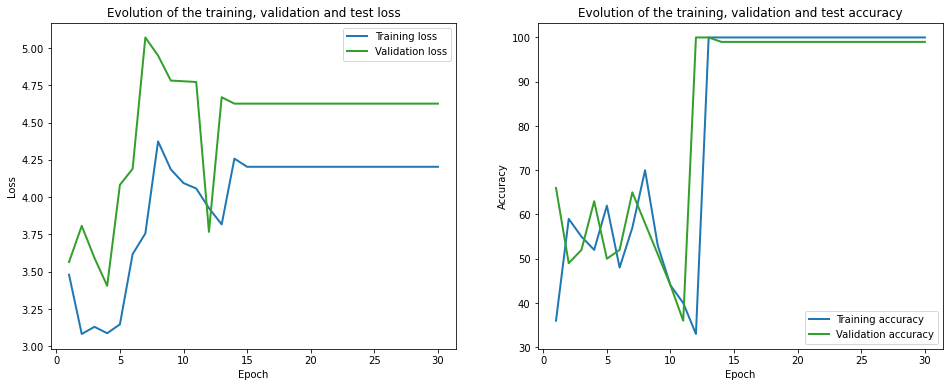

Computing standard benchmark p-values for 500 test points...
Calibrating each model in the list...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.23it/s]


Initialization done!


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 688.69it/s]

Finished computing p-values for 500 test points.
Training with CES data splitting...



C:\Users\16266\AppData\Local\Temp\ipykernel_17296\2573961132.py:70: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  th.nn.init.xavier_uniform(m.weight)


===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 30
learning_rate= 1
Epoch 1 of 30, 10% 	 train_loss: 2.77 train_acc: 30.00% took: 0.00s
Epoch 1 of 30, 20% 	 train_loss: 2.64 train_acc: 35.00% took: 0.00s
Epoch 1 of 30, 30% 	 train_loss: 3.06 train_acc: 50.00% took: 0.00s
Epoch 1 of 30, 40% 	 train_loss: 2.23 train_acc: 35.00% took: 0.01s
Epoch 1 of 30, 50% 	 train_loss: 2.00 train_acc: 40.00% took: 0.00s
Epoch 1 of 30, 60% 	 train_loss: 2.49 train_acc: 55.00% took: 0.00s
Epoch 1 of 30, 70% 	 train_loss: 3.07 train_acc: 40.00% took: 0.00s
Epoch 1 of 30, 80% 	 train_loss: 1.98 train_acc: 40.00% took: 0.01s
Epoch 1 of 30, 90% 	 train_loss: 4.20 train_acc: 45.00% took: 0.01s
Epoch 1 of 30, 100% 	 train_loss: 3.16 train_acc: 55.00% took: 0.00s
val_loss = 3.26 val_acc = 50.00%
Snapshot saved at epoch 1.
Epoch 2 of 30, 10% 	 train_loss: 1.71 train_acc: 55.00% took: 0.01s
Epoch 2 of 30, 20% 	 train_loss: 2.14 train_acc: 60.00% took: 0.00s
Epoch 2 of 30, 30% 	 train_loss: 2.56 train_acc: 5

Epoch 13 of 30, 90% 	 train_loss: 4.05 train_acc: 50.00% took: 0.00s
Epoch 13 of 30, 100% 	 train_loss: 3.16 train_acc: 55.00% took: 0.01s
val_loss = 3.24 val_acc = 60.00%
Snapshot saved at epoch 13.
Epoch 14 of 30, 10% 	 train_loss: 1.63 train_acc: 60.00% took: 0.01s
Epoch 14 of 30, 20% 	 train_loss: 2.13 train_acc: 60.00% took: 0.01s
Epoch 14 of 30, 30% 	 train_loss: 2.53 train_acc: 60.00% took: 0.00s
Epoch 14 of 30, 40% 	 train_loss: 1.84 train_acc: 50.00% took: 0.01s
Epoch 14 of 30, 50% 	 train_loss: 1.67 train_acc: 55.00% took: 0.01s
Epoch 14 of 30, 60% 	 train_loss: 2.16 train_acc: 65.00% took: 0.01s
Epoch 14 of 30, 70% 	 train_loss: 2.91 train_acc: 60.00% took: 0.01s
Epoch 14 of 30, 80% 	 train_loss: 1.88 train_acc: 40.00% took: 0.01s
Epoch 14 of 30, 90% 	 train_loss: 4.05 train_acc: 50.00% took: 0.01s
Epoch 14 of 30, 100% 	 train_loss: 3.16 train_acc: 55.00% took: 0.00s
val_loss = 3.24 val_acc = 60.00%
Snapshot saved at epoch 14.
Epoch 15 of 30, 10% 	 train_loss: 1.63 train_acc

Epoch 26 of 30, 40% 	 train_loss: 1.84 train_acc: 50.00% took: 0.00s
Epoch 26 of 30, 50% 	 train_loss: 1.67 train_acc: 55.00% took: 0.01s
Epoch 26 of 30, 60% 	 train_loss: 2.16 train_acc: 65.00% took: 0.01s
Epoch 26 of 30, 70% 	 train_loss: 2.91 train_acc: 60.00% took: 0.00s
Epoch 26 of 30, 80% 	 train_loss: 1.88 train_acc: 40.00% took: 0.01s
Epoch 26 of 30, 90% 	 train_loss: 4.05 train_acc: 50.00% took: 0.01s
Epoch 26 of 30, 100% 	 train_loss: 3.16 train_acc: 55.00% took: 0.00s
val_loss = 3.24 val_acc = 70.00%
Snapshot saved at epoch 26.
Epoch 27 of 30, 10% 	 train_loss: 1.63 train_acc: 60.00% took: 0.01s
Epoch 27 of 30, 20% 	 train_loss: 2.13 train_acc: 60.00% took: 0.01s
Epoch 27 of 30, 30% 	 train_loss: 2.53 train_acc: 60.00% took: 0.01s
Epoch 27 of 30, 40% 	 train_loss: 1.84 train_acc: 50.00% took: 0.00s
Epoch 27 of 30, 50% 	 train_loss: 1.67 train_acc: 55.00% took: 0.00s
Epoch 27 of 30, 60% 	 train_loss: 2.16 train_acc: 65.00% took: 0.01s
Epoch 27 of 30, 70% 	 train_loss: 2.91 tr

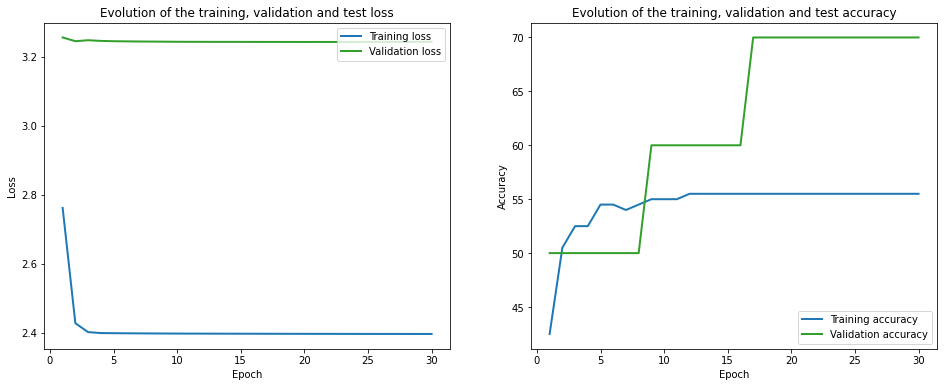

Calibrating each model in the list...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.21it/s]


Initialization done!
Computing naive benchmark p-values for 500 test points...


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 497.28it/s]

Finished computing p-values for 500 test points.


In [10]:
def add_header(df):
    df["n_epoch"] = n_epoch
    df["n_calib"] = n_cal_bm
    return df

results = pd.DataFrame({})

for r in range(num_repetitions):
    print("\nStarting repetition {:d} of {:d}:\n".format(r+1, num_repetitions))
    sys.stdout.flush()
    
    # Change random seed for this repetition
    seed = 1000+r
    results_new = run_experiment(seed, train_set, n_train_bm, n_val_bm, n_cal_bm, 
                                 test_set, n_test, lr, n_epoch, alpha_list)
    results_new = add_header(results_new)
    results_new["Repetition"] = r
    results = pd.concat([results, results_new])

In [11]:
sb_results = results[results["Method"]=="Standard benchmark"]
nb_results = results[results["Method"]=="Naive benchmark"]

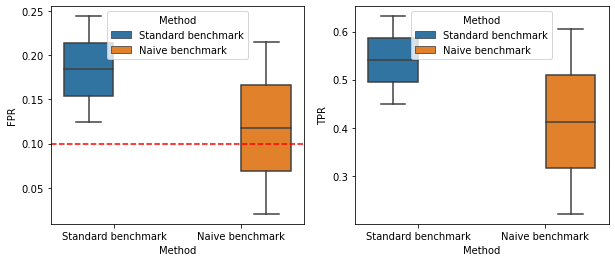

In [12]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="Fixed-FPR", x="Method", hue="Method", data=results, ax=ax1)
ax1.set(xlabel='Method', ylabel='FPR')
ax1.axhline(alpha_list[0], ls='--', color="red")
ax1.legend(loc='upper center', title='Method')

sns.boxplot(y="Fixed-TPR", x="Method", hue="Method", data=results, ax=ax2)
ax2.set(xlabel='Method', ylabel='TPR')
ax2.legend(loc='upper center', title='Method')
plt.show()

In [13]:
results

,Alpha,BH-Rejections,BH-FDP,BH-Power,Storey-BH-Rejections,Storey-BH-FDP,Storey-BH-Power,Fixed-Rejections,Fixed-FPR,Fixed-TPR,Method,n_epoch,n_calib,Repetition
0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,146.0,0.123967,0.449612,Standard benchmark,30,10,0
0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,208.0,0.214876,0.604651,Naive benchmark,30,10,0
0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,222.0,0.243802,0.631783,Standard benchmark,30,10,1
0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,0.020661,0.220930,Naive benchmark,30,10,1
